# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import datetime as dt

import warnings; warnings.simplefilter('ignore')
import gc #garbage collector

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
# Importamos el csv del 2019
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2019.head()

periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [3]:
# Importamos el csv del 2018
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2018.head()

periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [4]:
# Importamos el csv del 2017
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')
data_2017.head()

periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del set 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [5]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [6]:
garbage = gc.collect()

In [7]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.rename(columns = {'fecha':'fecha_original'}, inplace = True) 

dataset.head()

fecha_original  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos  \
80      2019-01-01         2  Martes     Centro       Liviano             537   
86      2019-01-01         2  Martes     Centro        Pesado               1   
88      2019-01-01         2  Martes  Provincia       Liviano             443   
94      2019-01-01         2  Martes  Provincia        Pesado               1   
149     2019-01-01         3  Martes     Centro       Liviano             769   

                 fecha2  
80  2019-01-01 02:00:00  
86  2019-01-01 02:00:00  
88  2019-01-01 02:00:00  
94  2019-01-01 02:00:00  
149 2019-01-01 03:00:00

In [8]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

fecha_original  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos  \
80      2019-01-01         2  Martes     Centro       Liviano             537   
86      2019-01-01         2  Martes     Centro        Pesado               1   
88      2019-01-01         2  Martes  Provincia       Liviano             443   
94      2019-01-01         2  Martes  Provincia        Pesado               1   
149     2019-01-01         3  Martes     Centro       Liviano             769   

                  fecha  
80  2019-01-01 02:00:00  
86  2019-01-01 02:00:00  
88  2019-01-01 02:00:00  
94  2019-01-01 02:00:00  
149 2019-01-01 03:00:00

In [9]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

fecha_original  hora_fin      dia    sentido tipo_vehiculo  \
0          2017-01-01         0  Domingo  Provincia        Pesado   
1          2017-01-01         0  Domingo  Provincia       Liviano   
2          2017-01-01         0  Domingo  Provincia       Liviano   
3          2017-01-01         0  Domingo  Provincia        Pesado   
4          2017-01-01         0  Domingo  Provincia        Pesado   
...               ...       ...      ...        ...           ...   
238864     2019-12-31        22   Martes  Provincia       Liviano   
238865     2019-12-31        22   Martes  Provincia        Pesado   
238866     2019-12-31        22   Martes     Centro       Liviano   
238867     2019-12-31        23   Martes     Centro       Liviano   
238868     2019-12-31        23   Martes  Provincia       Liviano   

        cantidad_pasos               fecha  
0                    1 2017-01-01 00:00:00  
1                    9 2017-01-01 00:00:00  
2                  644 2017-01-01 00:00:00  
3                    6 2017-01-01 00:00:00  
4                    1 2017-01-01 00:00:00  
...                ...                 ...  
238864             556 2019-12-31 22:00:00  
238865               1 2019-12-31 22:00:00  
238866             580 2019-12-31 22:00:00  
238867             214 2019-12-31 23:00:00  
238868             190 2019-12-31 23:00:00  

[238869 rows x 7 columns]

In [10]:
# Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 2)


hora_fin  cantidad_pasos
fecha                               
2017-01-01      2976           31183
2017-01-02      3713           51568
2017-01-03      3573           51093
2017-01-04      3909           53332
2017-01-05      3820           56486

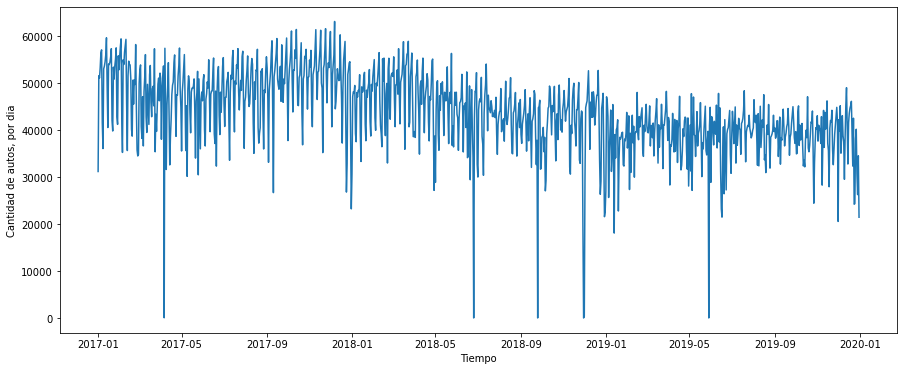

In [11]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

## ¿Cuáles son los días y horarios de mayor tráfico? 

#### Obtencion del dia de mayor trafico:

**Se puede observar que el día Viernes es el de mayor trafico vehicular**

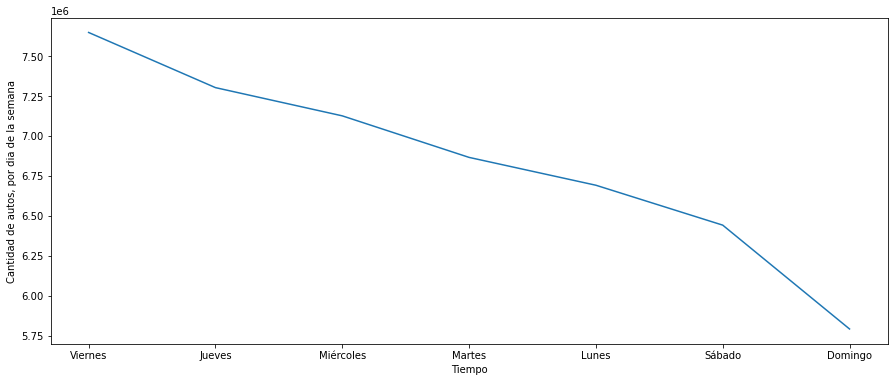

In [12]:
# agrupar por dia de la semana
dia_semana = dataset.groupby(by = "dia")["cantidad_pasos"].sum().sort_values(ascending=False)
# dia_semana.head(7)
printmd("**Se puede observar que el día Viernes es el de mayor trafico vehicular**")
plt.figure(figsize = (15,6))
plt.plot(dia_semana)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia de la semana')
plt.show()

**Se puede observar que las el horario pico es a las 18:00Hs**

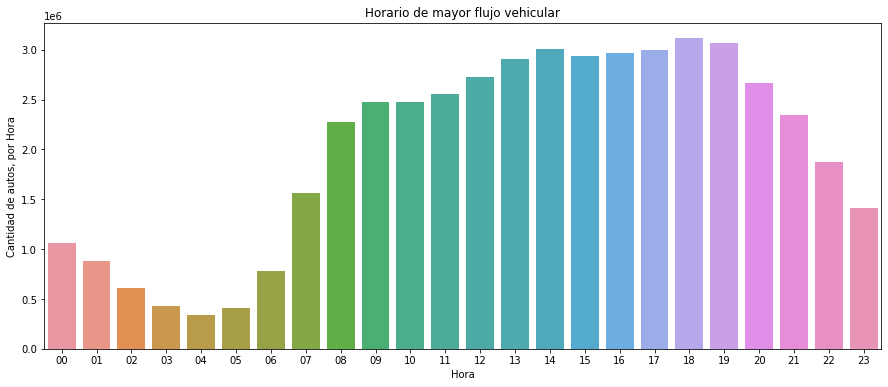

In [13]:
# agrupar por hora
hora = dataset.groupby(by = "hora_fin")["cantidad_pasos"].sum().sort_values(ascending=True)
# hora.head(10)
df = hora.to_frame()
x = df['cantidad_pasos']

data = [
    ['00', x[0]], ['01', x[1]], ['02', x[2]], ['03', x[3]], ['04', x[4]], ['05', x[5]], ['06', x[6]], 
    ['07', x[7]], ['08', x[8]], ['09', x[9]], ['10', x[10]], ['11', x[11]], ['12', x[12]], ['13', x[13]], 
    ['14', x[14]], ['15', x[15]], ['16', x[16]], ['17', x[17]], ['18', x[18]], ['19', x[19]], ['20', x[20]], 
    ['21', x[21]], ['22', x[22]], ['23', x[23]]
    ]

# # Create the pandas DataFrame 
por_hora = pd.DataFrame(data, columns = ['Hora', 'Vehiculos']) 
# por_hora
printmd("**Se puede observar que las el horario pico es a las 18:00Hs**")
plt.figure(figsize = (15,6))
sns.barplot(x=por_hora['Hora'], y=por_hora['Vehiculos'])
plt.xlabel('Hora')
plt.ylabel('Cantidad de autos, por Hora')
plt.title('Horario de mayor flujo vehicular')
plt.show()

**Se puede observar una tendencia negativa en la cantidad de vehiculos que pagan en efectivo**

**Será que eligen otros medios de pago?**

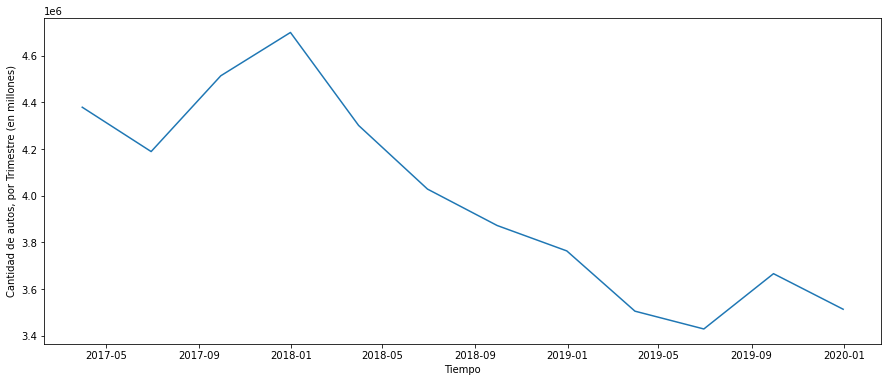

In [14]:
## por Trimestre usando resample
por_mes = dataset.resample('Q', on = 'fecha').sum()
por_mes.drop(columns = ['hora_fin'], inplace = True)
# por_mes.head()

printmd("**Se puede observar una tendencia negativa en la cantidad de vehiculos que pagan en efectivo**")
printmd("**Será que eligen otros medios de pago?**")

plt.figure(figsize = (15,6))
plt.plot(por_mes.index, por_mes.cantidad_pasos)
# plt.xlim(datetime.date(2019,1,1), datetime.date(2020,1,1))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por Trimestre (en millones)')
plt.show()

## Analizamos el flujo vehicular para todos los medios de pago

In [15]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset2 = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
dataset2 = dataset2[dataset2.estacion=='Illia']

# Reformateamos la fecha y hora
dataset2['fecha2'] = pd.to_datetime(dataset2.fecha) + pd.to_timedelta(dataset2.hora_fin, unit = 'h')
dataset2.drop(columns=['fecha'], inplace = True)
dataset2.rename(columns = {'fecha2':'fecha'}, inplace = True) 

dataset2.head()

periodo  hora_inicio  hora_fin     dia estacion    sentido tipo_vehiculo  \
19     2019            0         1  Martes    Illia     Centro       Liviano   
20     2019            0         1  Martes    Illia     Centro       Liviano   
21     2019            0         1  Martes    Illia     Centro        Pesado   
22     2019            0         1  Martes    Illia  Provincia       Liviano   
23     2019            0         1  Martes    Illia  Provincia       Liviano   

    forma_pago  cantidad_pasos               fecha  
19  NO COBRADO             146 2019-01-01 01:00:00  
20    TELEPASE              59 2019-01-01 01:00:00  
21    TELEPASE               1 2019-01-01 01:00:00  
22  NO COBRADO             147 2019-01-01 01:00:00  
23    TELEPASE             106 2019-01-01 01:00:00

**Al comparar todos los medios de pago, notamos que a medida que desciende el uso de efectivo, aumenta el telepase**

**Con lo cual podemos decir que la tendencia es negativa para el pago en efectivo, pero no asi el flujo de vehiculos**

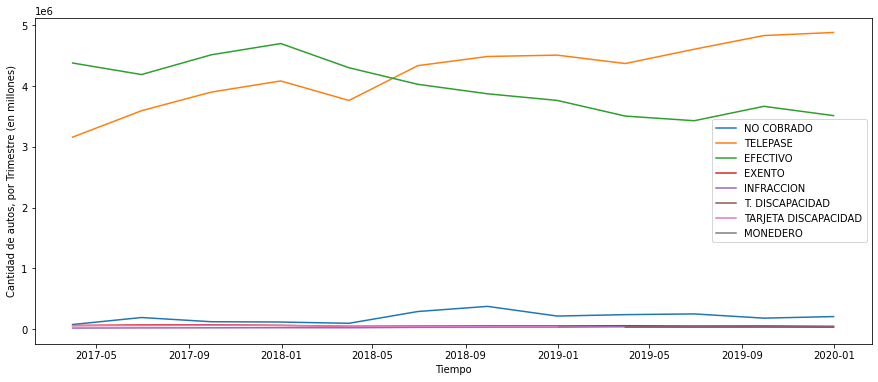

In [16]:
# Graficamos por forma de Pago
plt.figure(figsize = (15,6))
for formaPago in dataset2['forma_pago'].unique():
    newDataSet = dataset2[dataset2.forma_pago==formaPago]
    trimestral = newDataSet.resample('Q', on = 'fecha').sum()
    trimestral.drop(columns = ['hora_fin'], inplace = True)
    plt.plot(trimestral.index, trimestral.cantidad_pasos, label=formaPago)

printmd("**Al comparar todos los medios de pago, notamos que a medida que desciende el uso de efectivo, aumenta el telepase**")    
printmd("**Con lo cual podemos decir que la tendencia es negativa para el pago en efectivo, pero no asi el flujo de vehiculos**")    
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por Trimestre (en millones)')
plt.legend()
plt.show()    

## Existen valores atípicos en el dataset ?

In [17]:
print(dataset.isna().sum())
# No existen valores nulos

fecha_original    0
hora_fin          0
dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64


In [18]:
# Hay dias faltantes?


# Completamos los dias faltantes con el promedio del dia_anterior y dia_siguiente

arrDayOfWeek={0:'Domingo', 1:'Lunes', 2:'Martes', 3:'Miercoles', 4:'Jueves', 5:'Viernes', 6:'Sabado'}
def datetime_range(start=None, end=None):
    while start < end:
        ## existe ese dia?
        temp = dataset[(dataset.fecha == start)]
        if temp.empty:
            # No existe este dia, lo agregamos en null
            dds = int(start.strftime("%w"))
            dia_de_la_semana = arrDayOfWeek[dds]
            
            dia_anterior = start - timedelta(days=1)
            s_dia_anterior = dia_anterior.strftime("%Y-%m-%d")
            cantidad_anterior = dataset.cantidad_pasos[(dataset.fecha_original == s_dia_anterior)].sum()
            
            dia_siguiente  = start + timedelta(days=1)
            s_dia_siguiente = dia_siguiente.strftime("%Y-%m-%d")
            cantidad_siguiente = dataset.cantidad_pasos[(dataset.fecha_original == s_dia_siguiente)].sum()
            
            promedio = (cantidad_anterior + cantidad_siguiente) / 2
            fecha_original = start.strftime("%Y-%m-%d")
            
            ## Calcular directamente el promedio de los dias adyacentes
            dataset.loc[dataset.shape[0]] = [fecha_original,0, dia_de_la_semana, 'Provincia','Liviano', promedio, start] 
            print("Añadido el dia: ", start, promedio)
            
        start = start + timedelta(days=1)
        
datetime_range(start=datetime.strptime('2017-01-01', "%Y-%m-%d"), end=datetime.strptime('2019-12-31', "%Y-%m-%d"))


Añadido el dia:  2017-04-06 00:00:00 55537.0
Añadido el dia:  2017-11-04 00:00:00 48845.5
Añadido el dia:  2018-06-25 00:00:00 38312.5
Añadido el dia:  2018-09-25 00:00:00 41299.5
Añadido el dia:  2018-11-10 00:00:00 40806.0
Añadido el dia:  2018-11-29 00:00:00 21862.0
Añadido el dia:  2018-11-30 00:00:00 20970.0
Añadido el dia:  2019-02-11 00:00:00 39980.0
Añadido el dia:  2019-05-29 00:00:00 40353.5
Añadido el dia:  2019-12-24 00:00:00 33440.0


In [19]:
# Verificamos para una fecha que era faltante, y comprobamos que se agregó correctamente
temp = dataset[(dataset.fecha_original == '2019-05-29')]
temp

fecha_original  hora_fin        dia    sentido tipo_vehiculo  \
238877     2019-05-29         0  Miercoles  Provincia       Liviano   

        cantidad_pasos      fecha  
238877         40353.5 2019-05-29

In [20]:
dataset

fecha_original  hora_fin        dia    sentido tipo_vehiculo  \
0          2017-01-01         0    Domingo  Provincia        Pesado   
1          2017-01-01         0    Domingo  Provincia       Liviano   
2          2017-01-01         0    Domingo  Provincia       Liviano   
3          2017-01-01         0    Domingo  Provincia        Pesado   
4          2017-01-01         0    Domingo  Provincia        Pesado   
...               ...       ...        ...        ...           ...   
238874     2018-11-29         0     Jueves  Provincia       Liviano   
238875     2018-11-30         0    Viernes  Provincia       Liviano   
238876     2019-02-11         0      Lunes  Provincia       Liviano   
238877     2019-05-29         0  Miercoles  Provincia       Liviano   
238878     2019-12-24         0     Martes  Provincia       Liviano   

        cantidad_pasos      fecha  
0                  1.0 2017-01-01  
1                  9.0 2017-01-01  
2                644.0 2017-01-01  
3                  6.0 2017-01-01  
4                  1.0 2017-01-01  
...                ...        ...  
238874         21862.0 2018-11-29  
238875         20970.0 2018-11-30  
238876         39980.0 2019-02-11  
238877         40353.5 2019-05-29  
238878         33440.0 2019-12-24  

[238879 rows x 7 columns]

# Predicciónes
Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019.

In [21]:
# Copiamos el dataset
ds = dataset.copy()
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib

### Resample Semanal + StatsModel

In [22]:
semanal = ds.resample('W', on = 'fecha').sum().reset_index()
semanal.drop(columns = ['hora_fin'], inplace = True)

In [23]:
semanal

fecha  cantidad_pasos
0   2017-01-01         31183.0
1   2017-01-08        347212.0
2   2017-01-15        366413.0
3   2017-01-22        357215.0
4   2017-01-29        354581.0
..         ...             ...
153 2019-12-08        282891.0
154 2019-12-15        272960.0
155 2019-12-22        292881.0
156 2019-12-29        259830.0
157 2020-01-05         55970.0

[158 rows x 2 columns]

In [24]:
# Elimino la 1er y ultima semana, ya que estan incompletas
semanal.drop(0,axis=0, inplace=True)
semanal.drop(157,axis=0, inplace=True)
semanal.reset_index()

index      fecha  cantidad_pasos
0        1 2017-01-08        347212.0
1        2 2017-01-15        366413.0
2        3 2017-01-22        357215.0
3        4 2017-01-29        354581.0
4        5 2017-02-05        359401.0
..     ...        ...             ...
151    152 2019-12-01        266555.0
152    153 2019-12-08        282891.0
153    154 2019-12-15        272960.0
154    155 2019-12-22        292881.0
155    156 2019-12-29        259830.0

[156 rows x 3 columns]

In [25]:
# Seasonal
semanal = semanal.set_index('fecha')
result = seasonal_decompose(semanal.cantidad_pasos, model='additive')

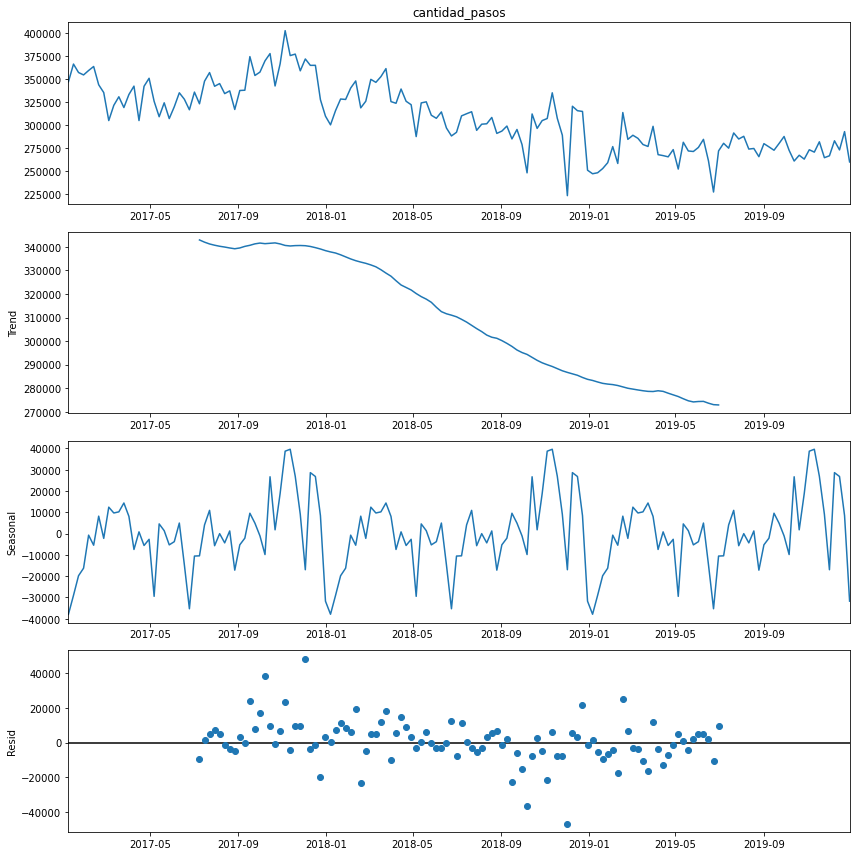

In [26]:
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

### Resultado resample semanal:
##### Claramente se puede observar una estacionalidad aditiva anual, y una tendencia negativa para el pago en efectivo

---------------------------


# Predicciones del ultimo trimestre 2019

## Benchmark

In [27]:
from sklearn.metrics import mean_squared_error
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn import linear_model

senial = semanal.cantidad_pasos
senial.tail()


fecha
2019-12-01    266555.0
2019-12-08    282891.0
2019-12-15    272960.0
2019-12-22    292881.0
2019-12-29    259830.0
Name: cantidad_pasos, dtype: float64

In [28]:
# En primer lugar, debemos definir cuántos valores hacia atrás tomaremos.
look_back = 52 # usamos un año (52 semanas) de datos para predecir el valor siguiente (estacionalidad)

# Creamos los X e y con ceros para luego llenar con los datos. Notar los shape
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

# Llenamos los X e y
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]


(103, 52) (103,)


In [29]:
N_test = 12 #cantidad de puntos que vamos a usar para evaluar
N_train = N - look_back - 1 - N_test # cantidad de instancias que vamos a usar para entrenar. 

N_total = N_train + N_test

length_total = N_train + N_test + look_back  

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_total]
print(X_test.shape, y_test.shape)

(91, 52) (91,)
(12, 52) (12,)


In [30]:
print(X_train)

[[347212.  366413.  357215.  ... 365063.  327602.  309692. ]
 [366413.  357215.  354581.  ... 327602.  309692.  300242. ]
 [357215.  354581.  359401.  ... 309692.  300242.  315780. ]
 ...
 [284913.  295210.  278806.5 ... 265594.  279775.  276271. ]
 [295210.  278806.5 247986.  ... 279775.  276271.  272592. ]
 [278806.5 247986.  312089.  ... 276271.  272592.  279927. ]]


In [31]:
## Creamos el diccionario para almacenar los MSE de cada modelo
MSE_dd = {}

# Creamos un df con las predicciones
predicciones = senial.index[-12:].to_frame() # Obtenemos de senial, las ultimas 12 semanas
predicciones['real'] = y_test # asignamos los valores reales del test para luego comparar con las predicciones
predicciones = predicciones.drop('fecha', axis=1).reset_index()

In [32]:
## Guardamos los datos del benchmark
# Benchmark: comparamos el error con el que habríamos obtenido si predecíamos copiando el valor de la fecha anterior.
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

predicciones['BenchMark'] = y_test_pred_benchmark # asignamos las predicciones del BenchMark

# Error del benchmark
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
b_mse = np.sqrt(MSE)
MSE_dd['Benchmark'] = b_mse


## One-Step Prediction

In [33]:
# Iteramos sobre distintos modelos y nos quedamos con los 2 que mejores resultados nos dieron
classifiers = [
    linear_model.BayesianRidge(),
#     linear_model.ARDRegression(),
#     linear_model.RidgeCV(),
#     linear_model.HuberRegressor(),
#     linear_model.RANSACRegressor(),
#     linear_model.LassoLars(),    
#     linear_model.SGDRegressor(),    
#     linear_model.PassiveAggressiveRegressor(),
#     linear_model.TheilSenRegressor(),
#     linear_model.ElasticNet(),
#     linear_model.Ridge(),
#     linear_model.PassiveAggressiveRegressor(),
#     linear_model.LinearRegression()
]

cual = 1
for item in classifiers:
#     print(item)
    clf = item
    clf.fit(X_train, y_train)
    # predecimos    
    y_pred = clf.predict(X)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)    
    if (cual==1):
        itemName = 'BayesianRidge'
    else:
        itemName = 'ARDRegression'
    cual = cual + 1    
    # guardamos la prediccion
    predicciones['OneStep-' + itemName] = y_test_pred # asignamos las predicciones
    # guardamos el MSE de test
    MSE = mean_squared_error(y_test, y_test_pred)
    MSE_dd['OneStep-' + itemName] = np.sqrt(MSE)


# Multi-Step Prediction

In [34]:
# Iteramos sobre distintos modelos y nos quedamos con los 2 que mejores resultados nos dieron
classifiers = [
    linear_model.BayesianRidge(),
#     linear_model.ARDRegression(),
#     linear_model.RidgeCV(),
#     linear_model.HuberRegressor(),
#     linear_model.RANSACRegressor(),
#     linear_model.LassoLars(),    
#     linear_model.SGDRegressor(),    
#     linear_model.PassiveAggressiveRegressor(),
#     linear_model.TheilSenRegressor(),
#     linear_model.ElasticNet(),
#     linear_model.Ridge(),
#     linear_model.PassiveAggressiveRegressor(),
#     linear_model.LinearRegression()
]

cual = 1
for item in classifiers:
#     print(item)
    clf = item
    clf.fit(X_train, y_train)    
    y_ms_test_pred = []
    x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
    for i in range(y_test.size):
        y_os_pred = clf.predict(x.reshape(1,-1))
        y_ms_test_pred.append(y_os_pred)
        x = np.append(x[1:], y_os_pred)
    y_ms_test_pred = np.array(y_ms_test_pred)    
    
    if (cual==1):
        itemName = 'BayesianRidge'
        br = clf
    else:
        itemName = 'ARDRegression'
    cual = cual + 1    
    # guardamos la prediccion
    predicciones['MultiStep-' + itemName] = y_ms_test_pred # asignamos las predicciones
    # guardamos el MSE de test
    MSE = mean_squared_error(y_test, y_ms_test_pred)
    MSE_dd['MultiStep-' + itemName] = np.sqrt(MSE)


In [35]:
MSE_dd

{'Benchmark': 11982.629653655606,
 'OneStep-BayesianRidge': 9688.906139950683,
 'MultiStep-BayesianRidge': 9612.879655243296}

### Optimizacion de Hiperparametros de MultiStep con BayesianRidge

In [36]:
# compute_score=True
clf = linear_model.BayesianRidge(n_iter=1000, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, 
                                 lambda_2=1e-06, alpha_init=None, lambda_init=None, compute_score=True, 
                                 fit_intercept=False, normalize=False, copy_X=True, verbose=False)

clf.fit(X_train, y_train)    
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = clf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)    
    
MSE = mean_squared_error(y_test, y_ms_test_pred)
MSE_dd['BayesianRidge-ComputerScore=True'] = np.sqrt(MSE)
    
predicciones['BayesianRidge-ComputerScore=True'] = y_ms_test_pred # asignamos las predicciones    

# Probamos con distintas optimizaciones pero la mejor sigue siendo la que viene por defecto

In [37]:
predicciones

fecha      real  BenchMark  OneStep-BayesianRidge  \
0  2019-10-13  272483.0   287568.0          260691.967838   
1  2019-10-20  260840.0   272483.0          264258.118769   
2  2019-10-27  267147.0   260840.0          269007.655532   
3  2019-11-03  262950.0   267147.0          276291.999152   
4  2019-11-10  273129.0   262950.0          280876.453393   
5  2019-11-17  270536.0   273129.0          283792.347294   
6  2019-11-24  281790.0   270536.0          278172.616867   
7  2019-12-01  264500.0   281790.0          277890.121865   
8  2019-12-08  266555.0   264500.0          274007.645345   
9  2019-12-15  282891.0   266555.0          276544.447009   
10 2019-12-22  272960.0   282891.0          276384.660701   
11 2019-12-29  292881.0   272960.0          276798.950686   

    MultiStep-BayesianRidge  BayesianRidge-ComputerScore=True  
0             260691.967838                     251105.369220  
1             263347.799134                     253705.363002  
2             269143.503754                     257686.359498  
3             276803.035916                     264712.980196  
4             281663.922159                     267347.031470  
5             284650.686289                     269517.824175  
6             278722.782308                     261655.701519  
7             277994.632641                     260127.057769  
8             274084.688041                     254947.632810  
9             277917.437497                     260716.477499  
10            275189.513826                     257075.399831  
11            278126.547172                     259673.794821

## Prophet

In [38]:
# Install on Anaconda: conda install -c conda-forge fbprophet
from fbprophet import Prophet

psemanal = ds.resample('W', on = 'fecha').sum().reset_index()
psemanal.drop(columns = ['hora_fin'], inplace = True)

psemanal.tail()

psemanal.drop(0,axis=0, inplace=True)
# ultimas 12 semanas, las eliminamos del dataset porque son las que vamos a predecir
psemanal.drop(range(145,158),axis=0, inplace=True)

Importing plotly failed. Interactive plots will not work.


In [39]:
psemanal.reset_index()

index      fecha  cantidad_pasos
0        1 2017-01-08        347212.0
1        2 2017-01-15        366413.0
2        3 2017-01-22        357215.0
3        4 2017-01-29        354581.0
4        5 2017-02-05        359401.0
..     ...        ...             ...
139    140 2019-09-08        276271.0
140    141 2019-09-15        272592.0
141    142 2019-09-22        279927.0
142    143 2019-09-29        287568.0
143    144 2019-10-06        272483.0

[144 rows x 3 columns]

In [40]:
psemanal = psemanal.rename(columns={'fecha': 'ds', 'cantidad_pasos': 'y'})
psemanal_model = Prophet(interval_width=0.95, weekly_seasonality=True)
psemanal_model.fit(psemanal)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
psemanal_forecast = psemanal_model.make_future_dataframe(periods=12, freq='W')
psemanal_forecast = psemanal_model.predict(psemanal_forecast)

In [42]:
psemanal_forecast.tail(12)

ds          trend     yhat_lower     yhat_upper    trend_lower  \
144 2019-10-13  271210.938499  240976.438099  302935.629226  271177.099458   
145 2019-10-20  270917.755776  247024.731301  311081.685238  270789.507399   
146 2019-10-27  270624.573053  263276.207108  327973.909396  270353.584639   
147 2019-11-03  270331.390330  276816.974870  342302.275293  269880.110603   
148 2019-11-10  270038.207607  277686.718756  340576.542725  269419.937799   
149 2019-11-17  269745.024884  262105.415043  324436.725275  268933.035259   
150 2019-11-24  269451.842161  247274.686094  312561.554738  268471.980243   
151 2019-12-01  269158.659438  245286.930028  307690.468823  267953.129321   
152 2019-12-08  268865.476715  253399.048426  316914.993974  267453.355028   
153 2019-12-15  268572.293992  256151.364865  320171.173065  266911.701331   
154 2019-12-22  268279.111269  245824.920879  313744.037786  266320.265819   
155 2019-12-29  267985.928546  227817.873846  289905.418971  265791.526866   

       trend_upper  additive_terms  additive_terms_lower  \
144  271248.454119       89.365663             89.365663   
145  271046.882360     8266.166201           8266.166201   
146  270857.420939    25753.602329          25753.602329   
147  270755.247488    39535.370534          39535.370534   
148  270661.758786    38011.946207          38011.946207   
149  270561.605649    23381.904023          23381.904023   
150  270506.528347     9818.883371           9818.883371   
151  270420.127170     8760.529024           8760.529024   
152  270303.258501    17100.129939          17100.129939   
153  270257.284078    20997.763386          20997.763386   
154  270143.151667    10877.376232          10877.376232   
155  270130.772352    -8620.998631          -8620.998631   

     additive_terms_upper      weekly  weekly_lower  weekly_upper  \
144             89.365663  279.449033    279.449033    279.449033   
145           8266.166201  279.449033    279.449033    279.449033   
146          25753.602329  279.449033    279.449033    279.449033   
147          39535.370534  279.449033    279.449033    279.449033   
148          38011.946207  279.449033    279.449033    279.449033   
149          23381.904023  279.449033    279.449033    279.449033   
150           9818.883371  279.449033    279.449033    279.449033   
151           8760.529024  279.449033    279.449033    279.449033   
152          17100.129939  279.449033    279.449033    279.449033   
153          20997.763386  279.449033    279.449033    279.449033   
154          10877.376232  279.449033    279.449033    279.449033   
155          -8620.998631  279.449033    279.449033    279.449033   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
144   -190.083371   -190.083371   -190.083371                   0.0   
145   7986.717167   7986.717167   7986.717167                   0.0   
146  25474.153296  25474.153296  25474.153296                   0.0   
147  39255.921501  39255.921501  39255.921501                   0.0   
148  37732.497173  37732.497173  37732.497173                   0.0   
149  23102.454990  23102.454990  23102.454990                   0.0   
150   9539.434338   9539.434338   9539.434338                   0.0   
151   8481.079991   8481.079991   8481.079991                   0.0   
152  16820.680906  16820.680906  16820.680906                   0.0   
153  20718.314352  20718.314352  20718.314352                   0.0   
154  10597.927199  10597.927199  10597.927199                   0.0   
155  -8900.447664  -8900.447664  -8900.447664                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper           yhat  
144                         0.0                         0.0  271300.304162  
145                         0.0                         0.0  279183.921977  
146                         0.0                         0.0  296378.175382  
147                         0.0                         0.0  309866.760864  
148      

<Figure size 1296x432 with 0 Axes>

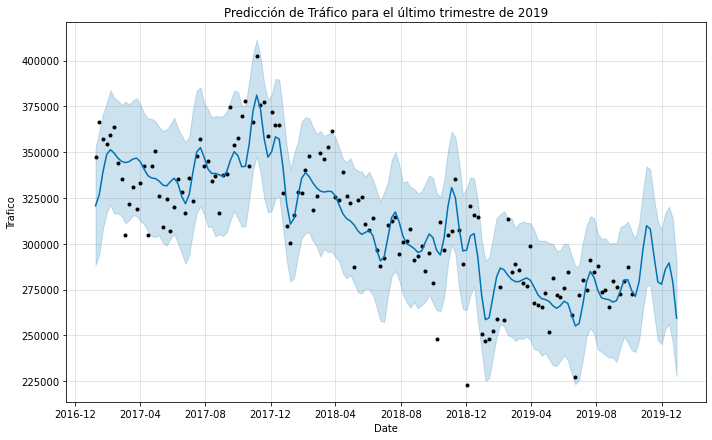

In [43]:
plt.figure(figsize=(18, 6))
psemanal_model.plot(psemanal_forecast, xlabel = 'Date', ylabel = 'Trafico')
plt.title('Predicción de Tráfico para el último trimestre de 2019');

In [44]:
# Obtenemos las ultimas 12 semanas de la prediccion para poder calcular el MSE
prophet_pred = psemanal_forecast.drop(range(0,144),axis=0)
y_prophet_pred = prophet_pred['yhat'] 
y_prophet_pred.reset_index(level=None, drop=True, inplace=True)
predicciones['Prophet'] = y_prophet_pred # asignamos las predicciones


In [45]:
MSE = mean_squared_error(y_test, y_prophet_pred)
MSE_dd['Prohet'] = np.sqrt(MSE)
MSE_df = pd.DataFrame.from_dict(MSE_dd, orient='index')

MSE_df.reset_index(inplace=True)
MSE_df.columns = ["modelo","rmse"]
MSE_df

modelo          rmse
0                         Benchmark  11982.629654
1             OneStep-BayesianRidge   9688.906140
2           MultiStep-BayesianRidge   9612.879655
3  BayesianRidge-ComputerScore=True  15919.008086
4                            Prohet  23966.827060

### Aquí se puede observar que el modelo con menor RMSE es el "MultiStep-BayesianRidge"

<AxesSubplot:xlabel='modelo', ylabel='rmse'>

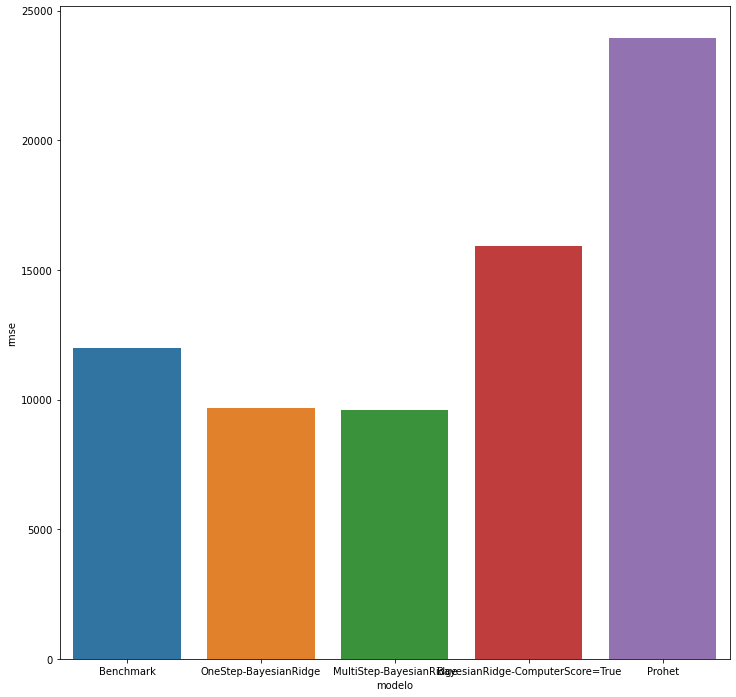

In [46]:
# Graficamos los RMSE
sns.barplot(x='modelo', y='rmse', data=MSE_df)

### Vemos la tabla con las distintas predicciones realizadas

In [47]:
predicciones.set_index('fecha', inplace=True)
predicciones

real  BenchMark  OneStep-BayesianRidge  \
fecha                                                    
2019-10-13  272483.0   287568.0          260691.967838   
2019-10-20  260840.0   272483.0          264258.118769   
2019-10-27  267147.0   260840.0          269007.655532   
2019-11-03  262950.0   267147.0          276291.999152   
2019-11-10  273129.0   262950.0          280876.453393   
2019-11-17  270536.0   273129.0          283792.347294   
2019-11-24  281790.0   270536.0          278172.616867   
2019-12-01  264500.0   281790.0          277890.121865   
2019-12-08  266555.0   264500.0          274007.645345   
2019-12-15  282891.0   266555.0          276544.447009   
2019-12-22  272960.0   282891.0          276384.660701   
2019-12-29  292881.0   272960.0          276798.950686   

            MultiStep-BayesianRidge  BayesianRidge-ComputerScore=True  \
fecha                                                                   
2019-10-13            260691.967838                     251105.369220   
2019-10-20            263347.799134                     253705.363002   
2019-10-27            269143.503754                     257686.359498   
2019-11-03            276803.035916                     264712.980196   
2019-11-10            281663.922159                     267347.031470   
2019-11-17            284650.686289                     269517.824175   
2019-11-24            278722.782308                     261655.701519   
2019-12-01            277994.632641                     260127.057769   
2019-12-08            274084.688041                     254947.632810   
2019-12-15            277917.437497                     260716.477499   
2019-12-22            275189.513826                     257075.399831   
2019-12-29            278126.547172                     259673.794821   

                  Prophet  
fecha                      
2019-10-13  271300.304162  
2019-10-20  279183.921977  
2019-10-27  296378.175382  
2019-11-03  309866.760864  
2019-11-10  308050.153814  
2019-11-17  293126.928907  
2019-11-24  279270.725533  
2019-12-01  277919.188463  
2019-12-08  285965.606655  
2019-12-15  289570.057378  
2019-12-22  279156.487501  
2019-12-29  259364.929916

<AxesSubplot:xlabel='fecha'>

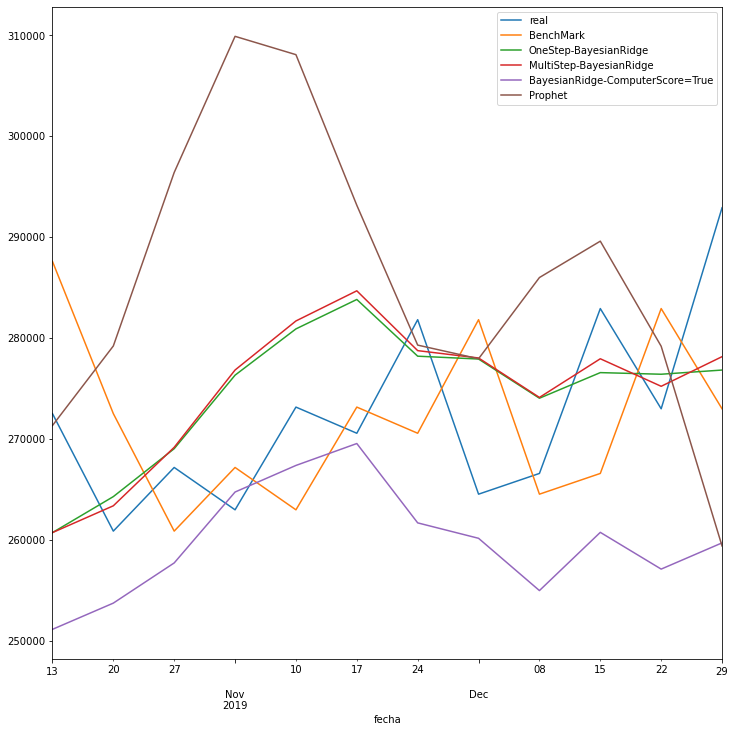

In [48]:
# Graficamos todas las predicciones realizadas
predicciones.plot()

# Prediccion para el año 2020 con Prophet

In [49]:
set_semanal = ds.resample('W', on = 'fecha').sum().reset_index()
set_semanal.drop(columns = ['hora_fin'], inplace = True)

set_semanal.tail()

set_semanal.drop(0,axis=0, inplace=True) # Eliminamos la 1er semana
set_semanal.drop(range(157,158),axis=0, inplace=True) # Eliminamos la ultima semana

set_semanal.reset_index()

index      fecha  cantidad_pasos
0        1 2017-01-08        347212.0
1        2 2017-01-15        366413.0
2        3 2017-01-22        357215.0
3        4 2017-01-29        354581.0
4        5 2017-02-05        359401.0
..     ...        ...             ...
151    152 2019-12-01        266555.0
152    153 2019-12-08        282891.0
153    154 2019-12-15        272960.0
154    155 2019-12-22        292881.0
155    156 2019-12-29        259830.0

[156 rows x 3 columns]

In [50]:
set_semanal = set_semanal.rename(columns={'fecha': 'ds', 'cantidad_pasos': 'y'})
model = Prophet(interval_width=0.95, weekly_seasonality=True)
model.fit(set_semanal)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
pro2020_forecast = model.make_future_dataframe(periods=52, freq='W')
pro2020_forecast = model.predict(pro2020_forecast)
pro2020_forecast.tail(12)

ds          trend     yhat_lower     yhat_upper    trend_lower  \
196 2020-10-11  237556.396646  206762.267886  273387.852686  226358.059468   
197 2020-10-18  237050.700894  206319.860266  272574.684719  225138.523129   
198 2020-10-25  236545.005141  218051.937634  283646.489695  224261.994184   
199 2020-11-01  236039.309388  229521.498546  297594.883329  223485.650880   
200 2020-11-08  235533.613635  230438.800260  301819.824935  222704.482614   
201 2020-11-15  235027.917882  221704.782236  291727.106544  221843.973172   
202 2020-11-22  234522.222130  212644.880925  276788.497937  220726.526712   
203 2020-11-29  234016.526377  206222.308846  277118.418830  219880.368183   
204 2020-12-06  233510.830624  212808.568548  283727.238407  219034.756662   
205 2020-12-13  233005.134871  219795.867231  292396.989779  218189.342690   
206 2020-12-20  232499.439118  214927.894675  285941.365259  217288.507620   
207 2020-12-27  231993.743366  197539.635341  268051.781076  216431.755980   

       trend_upper  additive_terms  additive_terms_lower  \
196  248923.125228     1191.483020           1191.483020   
197  248611.868712     3059.622035           3059.622035   
198  248539.107782    15125.499521          15125.499521   
199  248454.471972    28581.649928          28581.649928   
200  248323.758703    31597.524838          31597.524838   
201  248250.741615    21971.281993          21971.281993   
202  248255.250691    10009.153652          10009.153652   
203  248140.181908     7730.018139           7730.018139   
204  248019.232693    15858.776278          15858.776278   
205  247902.998038    22858.642017          22858.642017   
206  247892.203660    17111.792788          17111.792788   
207  247895.052708     -865.473492           -865.473492   

     additive_terms_upper       weekly  weekly_lower  weekly_upper  \
196           1191.483020  1044.439807   1044.439807   1044.439807   
197           3059.622035  1044.439807   1044.439807   1044.439807   
198          15125.499521  1044.439807   1044.439807   1044.439807   
199          28581.649928  1044.439807   1044.439807   1044.439807   
200          31597.524838  1044.439807   1044.439807   1044.439807   
201          21971.281993  1044.439807   1044.439807   1044.439807   
202          10009.153652  1044.439807   1044.439807   1044.439807   
203           7730.018139  1044.439807   1044.439807   1044.439807   
204          15858.776278  1044.439807   1044.439807   1044.439807   
205          22858.642017  1044.439807   1044.439807   1044.439807   
206          17111.792788  1044.439807   1044.439807   1044.439807   
207           -865.473492  1044.439807   1044.439807   1044.439807   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
196    147.043213    147.043213    147.043213                   0.0   
197   2015.182228   2015.182228   2015.182228                   0.0   
198  14081.059715  14081.059715  14081.059715                   0.0   
199  27537.210121  27537.210121  27537.210121                   0.0   
200  30553.085031  30553.085031  30553.085031                   0.0   
201  20926.842186  20926.842186  20926.842186                   0.0   
202   8964.713845   8964.713845   8964.713845                   0.0   
203   6685.578332   6685.578332   6685.578332                   0.0   
204  14814.336471  14814.336471  14814.336471                   0.0   
205  21814.202210  21814.202210  21814.202210                   0.0   
206  16067.352981  16067.352981  16067.352981                   0.0   
207  -1909.913299  -1909.913299  -1909.913299                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper           yhat  
196                         0.0                         0.0  238747.879667  
197                         0.0                         0.0  240110.322929  
198                         0.0                         0.0  251670.504662  
199                         0.0                         0.0  264620.95931

<Figure size 1296x432 with 0 Axes>

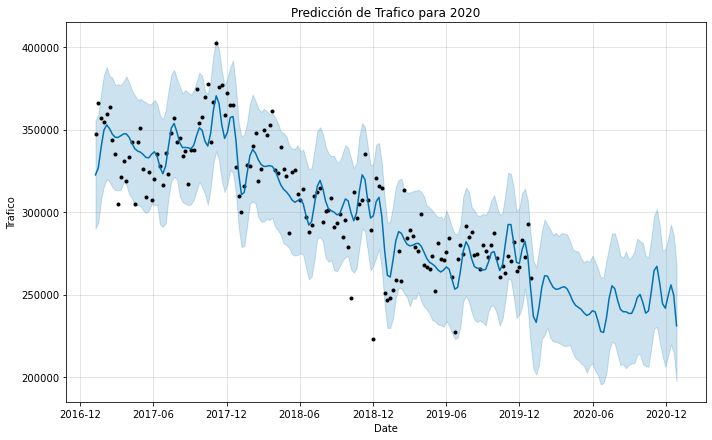

In [52]:
plt.figure(figsize=(18, 6))
model.plot(pro2020_forecast, xlabel = 'Date', ylabel = 'Trafico')
plt.title('Predicción de Trafico para 2020');


In [53]:
# Predicciones para el 2020
predicciones2020 = pro2020_forecast[['ds','yhat']]
predicciones2020 = predicciones2020.tail(52).reset_index()
predicciones2020.rename(columns = {'ds': 'fecha', 'yhat':'prophet'}, inplace = True)

In [54]:
predicciones2020.set_index('fecha', inplace=True)
predicciones2020.drop(columns = {"index"}, inplace = True)

In [55]:
# predicciones2020

## Predicciones 2020 con bayesianRidge

In [56]:
y_ms_test_pred = []
ultimo_anio = X[50:103] # Ultimos 52 items
x = ultimo_anio[0,:] # arrancamos con la primera instancias del conjunto de test

for i in range(52):
    y_os_pred = br.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
predicciones2020['bayesianRidge'] = np.array(y_ms_test_pred)

In [57]:
# predicciones2020

## Cargamos el dataset del 2020 para comparar con las predicciones

In [58]:
data_2020 = pd.read_csv('Datasets/flujo-vehicular-2020.csv', sep =',')

#Quitamos las columnas que no vamos a utilizar
data_2020.drop(columns = ['mes','dia_fecha','observacion'], inplace = True)

#Corregimos diferencias en este nuevo set
data_2020['estacion'].replace('ILLIA', 'Illia',  inplace=True)
# Corregimos la etiqueta forma_pago para el 2020
data_2020['forma_pago'].replace('Efectivo', 'EFECTIVO',  inplace=True)

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='Illia', data_2020.forma_pago == 'EFECTIVO')
data_2020 = data_2020[mask]

#Quitamos las columnas que no vamos a utilizar
data_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')
data_2020.drop(columns=['fecha'], inplace = True)
data_2020.drop(columns=['hora_fin'], inplace = True)

data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)

In [59]:
data_2020

dia   tipo_vehiculo    sentido  cantidad_pasos  \
0      Miércoles            Moto     Centro             7.0   
1      Miércoles            Auto  Provincia           423.0   
2      Miércoles            Auto     Centro           467.0   
3      Miércoles            Moto  Provincia             6.0   
4      Miércoles  Pesados 2 Ejes     Centro             1.0   
...          ...             ...        ...             ...   
52369     Jueves            Auto  Provincia           222.0   
52370     Jueves            Auto  Provincia           106.0   
52371     Jueves            Moto     Centro             5.0   
52372     Jueves            Moto  Provincia             1.0   
52373     Jueves            Auto     Centro           103.0   

                    fecha  
0     2020-01-01 00:00:00  
1     2020-01-01 00:00:00  
2     2020-01-01 00:00:00  
3     2020-01-01 00:00:00  
4     2020-01-01 00:00:00  
...                   ...  
52369 2020-12-31 20:00:00  
52370 2020-12-31 21:00:00  
52371 2020-12-31 21:00:00  
52372 2020-12-31 21:00:00  
52373 2020-12-31 21:00:00  

[52374 rows x 5 columns]

In [60]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
sem = data_2020.resample('W', on = 'fecha').sum()
print(sem.shape)
sem.head()

(53, 1)


cantidad_pasos
fecha                     
2020-01-05        150623.0
2020-01-12        243359.0
2020-01-19        246818.0
2020-01-26        241192.0
2020-02-02        253335.0

In [61]:
predicciones2020['real'] = sem

In [62]:
predicciones2020

prophet  bayesianRidge      real
fecha                                             
2020-01-05  236796.113042  290558.713952  150623.0
2020-01-12  233149.326251  275415.871194  243359.0
2020-01-19  242187.093762  275583.655221  246818.0
2020-01-26  254488.773408  270689.706527  241192.0
2020-02-02  261405.120813  276615.300187  253335.0
2020-02-09  261236.593000  271886.265345  247145.0
2020-02-16  257644.060693  281672.939391  261458.0
2020-02-23  254510.756226  279696.166485  257096.0
2020-03-01  253221.632542  288295.928226  235487.0
2020-03-08  253420.420204  283088.798914  254910.0
2020-03-15  254315.773527  284132.798682  222793.0
2020-03-22  254794.582980  280150.863922  107855.0
2020-03-29  253539.906877  285668.506497       0.0
2020-04-05  250204.865813  283074.626958       0.0
2020-04-12  246219.503987  285104.458068       0.0
2020-04-19  243511.351649  282622.356183       0.0
2020-04-26  242319.813140  290825.069219       0.0
2020-05-03  241098.027644  287065.439249       0.0
2020-05-10  238965.671872  279912.042415       0.0
2020-05-17  237370.927697  271655.728754       1.0
2020-05-24  238162.755064  277365.238950   50883.0
2020-05-31  240214.656199  277247.835905   54914.0
2020-06-07  239563.353598  283353.431237   70493.0
2020-06-14  234118.485398  277550.711320   76452.0
2020-06-21  227610.906438  279447.984155   71727.0
2020-06-28  227091.542982  276852.857248   81275.0
2020-07-05  235583.012626  272417.639191   73739.0
2020-07-12  247967.240610  271633.427088   60783.0
2020-07-19  255351.893009  281063.247456   78449.0
2020-07-26  253576.747494  279760.911510   84605.0
2020-08-02  246552.553604  283988.931566   92429.0
2020-08-09  241073.907361  280788.637799   93553.0
2020-08-16  239635.610646  282213.313797   93921.0
2020-08-23  239592.005481  279063.870158   81746.0
2020-08-30  238625.792284  278907.449710   82898.0
2020-09-06  238580.041751  273093.941640   77409.0
2020-09-13  242335.549478  273105.625428   78137.0
2020-09-20  248172.738061  271791.955269   69749.0
2020-09-27  250104.324047  277448.176129   61191.0
2020-10-04  245160.149615  279937.931246   34583.0
2020-10-11  238747.879667  277361.037581   35073.0
2020-10-18  240110.322929  269829.923060   37934.0
2020-10-25  251670.504662  272776.762967   36724.0
2020-11-01  264620.959316  275660.583535   44103.0
2020-11-08  267131.138473  278310.260963   48840.0
2020-11-15  256999.199875  281755.992168   53040.0
2020-11-22  244531.375781  282746.773973   61181.0
2020-11-29  241746.544516  279574.206518   58030.0
2020-12-06  249369.606902  278389.214163   68580.0
2020-12-13  255863.776889  274801.045075   65435.0
2020-12-20  249611.231906  278271.950045   73578.0
2020-12-27  231128.269874  278014.256220   67434.0

<AxesSubplot:xlabel='fecha'>

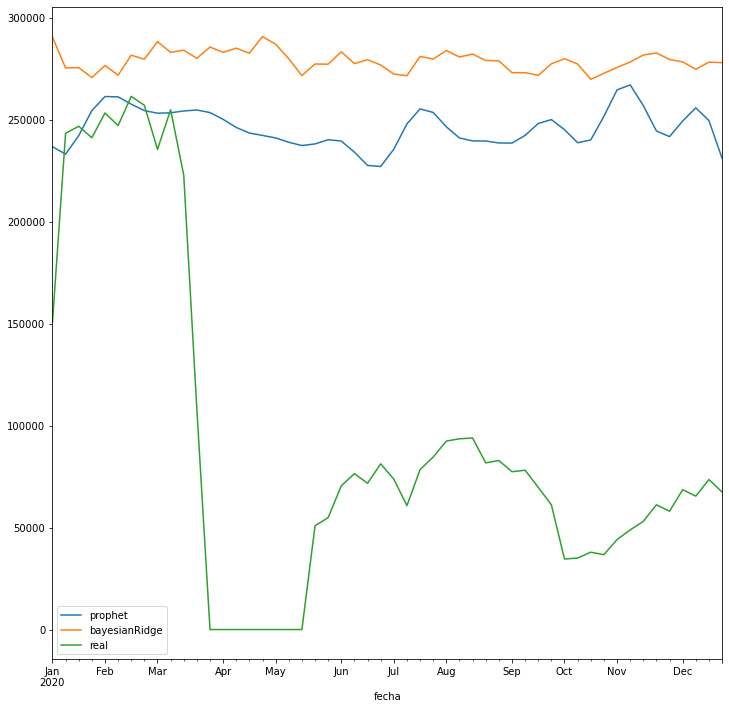

In [63]:
# Graficamos todas las predicciones realizadas
predicciones2020.plot()

### Analisis
- Cargué los dataset correspondientes a los años 2017-2018 y 2019; realice distintas transformaciones de datos respecto a renombrar columnas, agrupar y corregir valores faltantes
- Realice predicciones para el ultimo trimestre del 2019 del cual obteve las siguientes conclusiones:
    - Confeccioné un modelo Benchmark calculado en base al promedio del valor de la semana anterior y la semana siguiente
    - Probe distintos modelos de regresion lineal tanto para OneStep como para MultiStep y en ambos casos el mejor valor lo obtuve con bayesianRidge
    - En este ultimo realice pruebas alterando los hiperparámetros pero no obtuve un resultado mejor que con los valores por defectos
    - Tambien hice una prediccion utilizando Prophet y el resultado fue el peor de todos
- Para la prediccion del año 2020:
    - utilice bayesianRidge y Prophet 
    - Cargue los datos del csv2020, el cual tuve que intervenir con distintas correcciones ya que los datos son muy distintos a los años anteriores
    - Realice el grafico comparativo y se puede apreciar que en los 3 primeros meses los datos son consistentes, luego cuando se declara la pandemia y la restriccion de circulacion, estos valores descienden abruptamente
    - En la 2da mitad del año se va recomponiendo pero nunca llegan a los valores anteriores
    - Se puede apreciar en el primer trimestre, la prediccion mas acertada corresponde a Prophet
- Considerando que las restricciones de la pandemia, altero el flujo vehicular normal, va ser practicamente imposible conseguir un modelo que tenga una miy buena prediccion del 2020

- Próximos pasos:
    - Utilizaria el primer trimestre 2020 (prepandemia) para entrenar el modelo con train/test de igual manera que hice para predecir y verificar con el ultimo trimestre del 2019. 
    - Tambien probaria agregando otros medios de pago (como ser telepase) y otro tipo de vehiulos, ya que con la pandemia solo circularon los escenciales y los de carga mayoritariamente. 
    - Respecto a la incorporacion de años anteriores, no creo que mejore el rendimiento
    - Como mejora para el próximo proyecto implementaré un modelo ARIMA
